In [1]:
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import seaborn as sns
import warnings
import numpy as np

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize': (30, 10)})

import sys
import os

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"



sources :
 <https://ts.gluon.ai/stable/tutorials/forecasting/quick_start_tutorial.html>
 <https://aws.amazon.com/fr/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/>


## BTC-USD Hourly - Bitstamp

In [2]:
btc_usd_h = pd.read_csv("data/Bitstamp_BTCUSD_1h.csv")
btc_usd_h = btc_usd_h.iloc[::-1]
btc_usd_h = btc_usd_h[["date", "close"]]
btc_usd_h.set_index("date", inplace=True)
btc_usd_h.head()
btc_usd_h.shape

,close
date,
2018-05-15 06:00:00,8740.99
2018-05-15 07:00:00,8739.00
2018-05-15 08:00:00,8728.49
2018-05-15 09:00:00,8708.32
2018-05-15 10:00:00,8795.90


(38467, 1)

(96, 1)

<AxesSubplot:xlabel='date'>

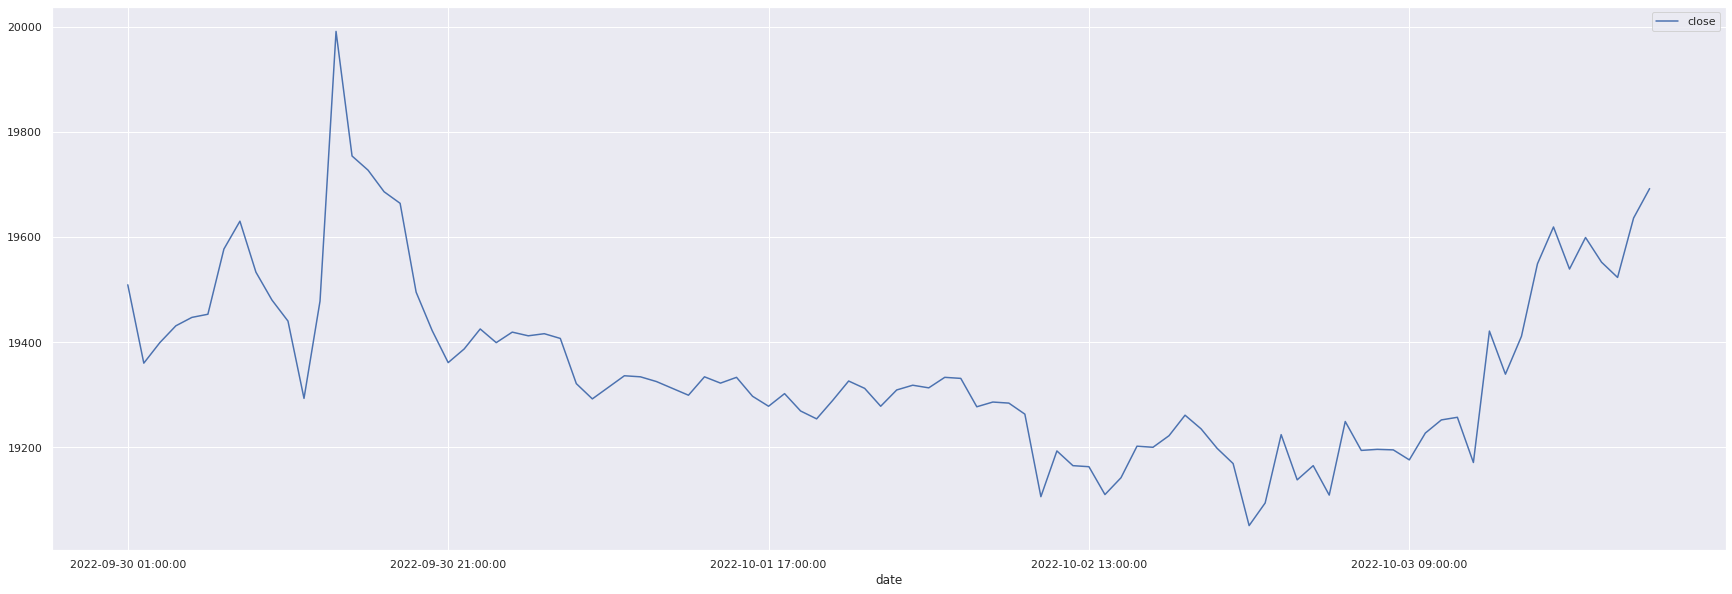

In [3]:
# let's keep only the latests values which represents the actual behavior
# + we should keep only the last 6 months for modeling
# + also, we should only try to predict at the maximum 3 months
btc_usd_h = btc_usd_h[btc_usd_h.index > "2022-09-30 00:00:00"]
btc_usd_h.shape
btc_usd_h.plot()

### Arima

#### Normalization

ARiMA models works beter with normalized data

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
btc_usd_h_scaled = btc_usd_h
btc_usd_h_scaled.close = scaler.fit_transform(np.array(btc_usd_h.close).reshape(-1,1))
# btc_usd_h.close = np.log(btc_usd_h.close)

In [5]:
from scalecast.Forecaster import Forecaster
from scalecast.auxmodels import auto_arima


In [6]:
def get_forecaster(data):
	f= Forecaster(y=data.close,current_dates=data.index)
	print(f)
	# generate 48hours
	f.generate_future_dates(72)
	f.set_test_length(.2) # 20% test set
	f.set_estimator('arima') # set arima
	return f

f = get_forecaster(btc_usd_h_scaled)


Forecaster(
    DateStartActuals=2022-09-30T01:00:00.000000000
    DateEndActuals=2022-10-04T00:00:00.000000000
    Freq=H
    N_actuals=96
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)


In [7]:
def test_stationarity(f: Forecaster):
	res = f.adf_test()
	stat, pval, _, _, _, _ = f.adf_test(full_res=True)
	print(f'stat: {stat}')
	print(f'p-value: {pval}')
	if (pval > 0.05):
		print("data is non-stationary, modify it to proceed  with ARIMA")
	else :
		print("data is stationary ! go on with ARIMA")
	return res

test_stationarity(f)

stat: -2.3532215412555284
p-value: 0.15537668627130108
data is non-stationary, modify it to proceed  with ARIMA


False

In [8]:
btc_usd_h_diff = btc_usd_h_scaled - btc_usd_h.shift().dropna()
f = get_forecaster(btc_usd_h_diff)
test_stationarity(f)
# plt.plot(btc_usd_h_diff)



Forecaster(
    DateStartActuals=2022-09-30T02:00:00.000000000
    DateEndActuals=2022-10-04T00:00:00.000000000
    Freq=H
    N_actuals=95
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)
stat: -10.97115699555006
p-value: 7.874250577605338e-20
data is stationary ! go on with ARIMA


True

ADF tests (null hypothesis) shows that pvalue is above the significance level of 0.05.

there is no reason to reject the null hypothesis, so the time serie is non-stationary

-> esperence, variance and auto-correlation vary upon time

<https://www.wikiwand.com/en/Augmented_Dickey%E2%80%93Fuller_test>

<https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/>

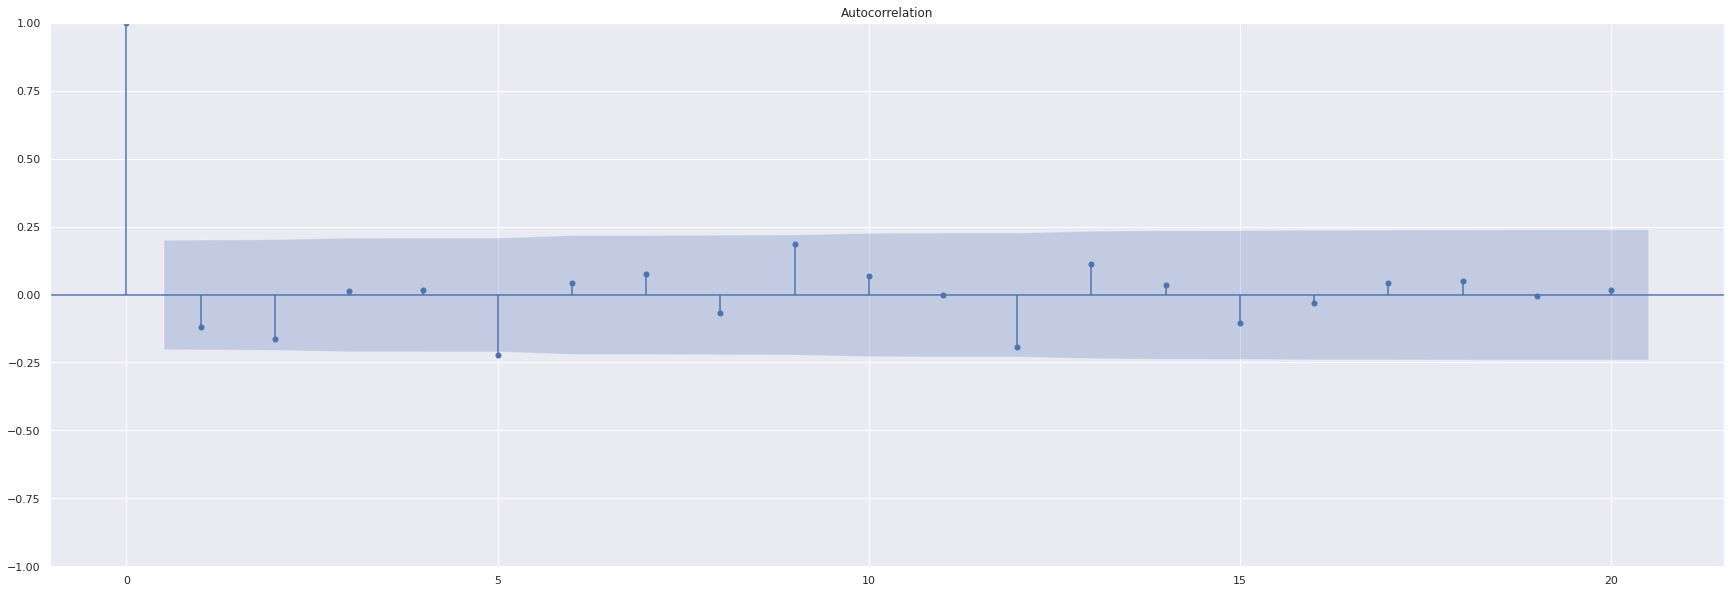

In [9]:
f.plot_acf();
plt.show();

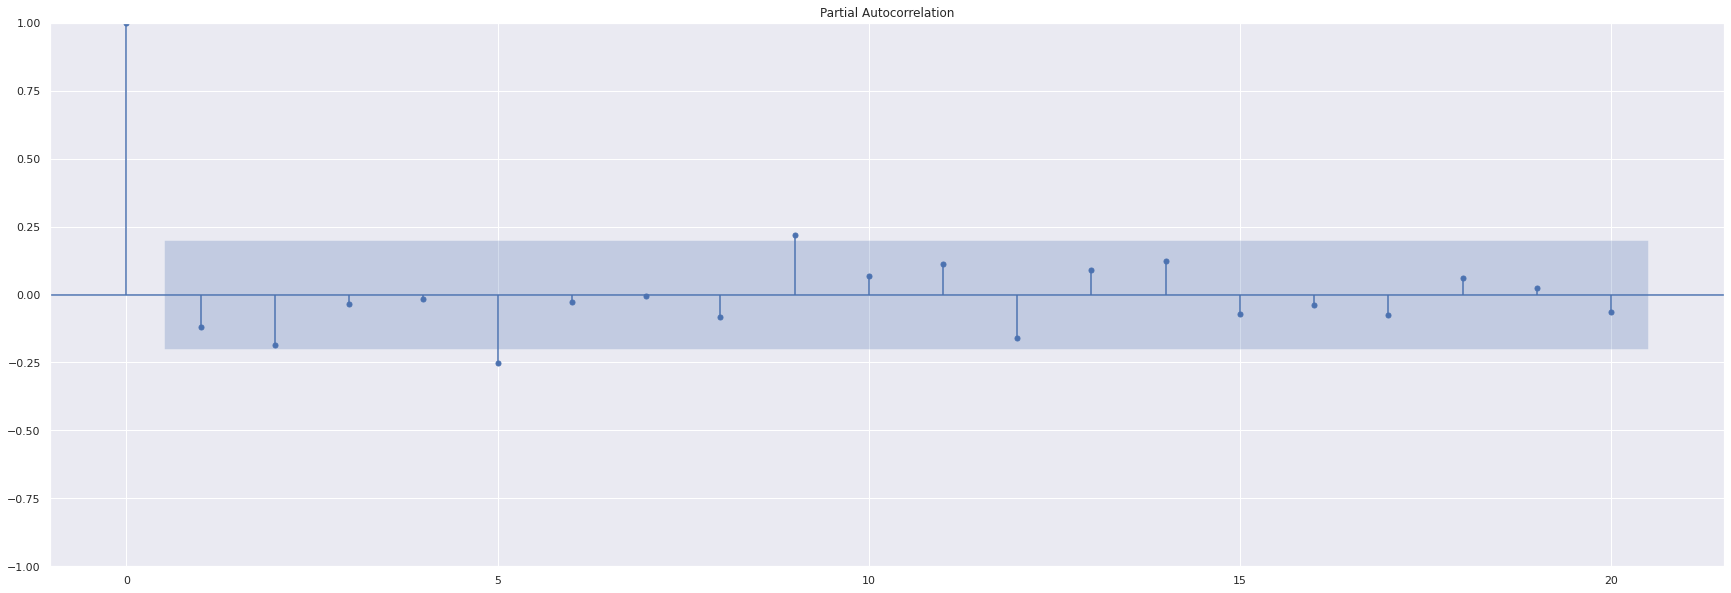

In [10]:
f.plot_pacf();
plt.show();

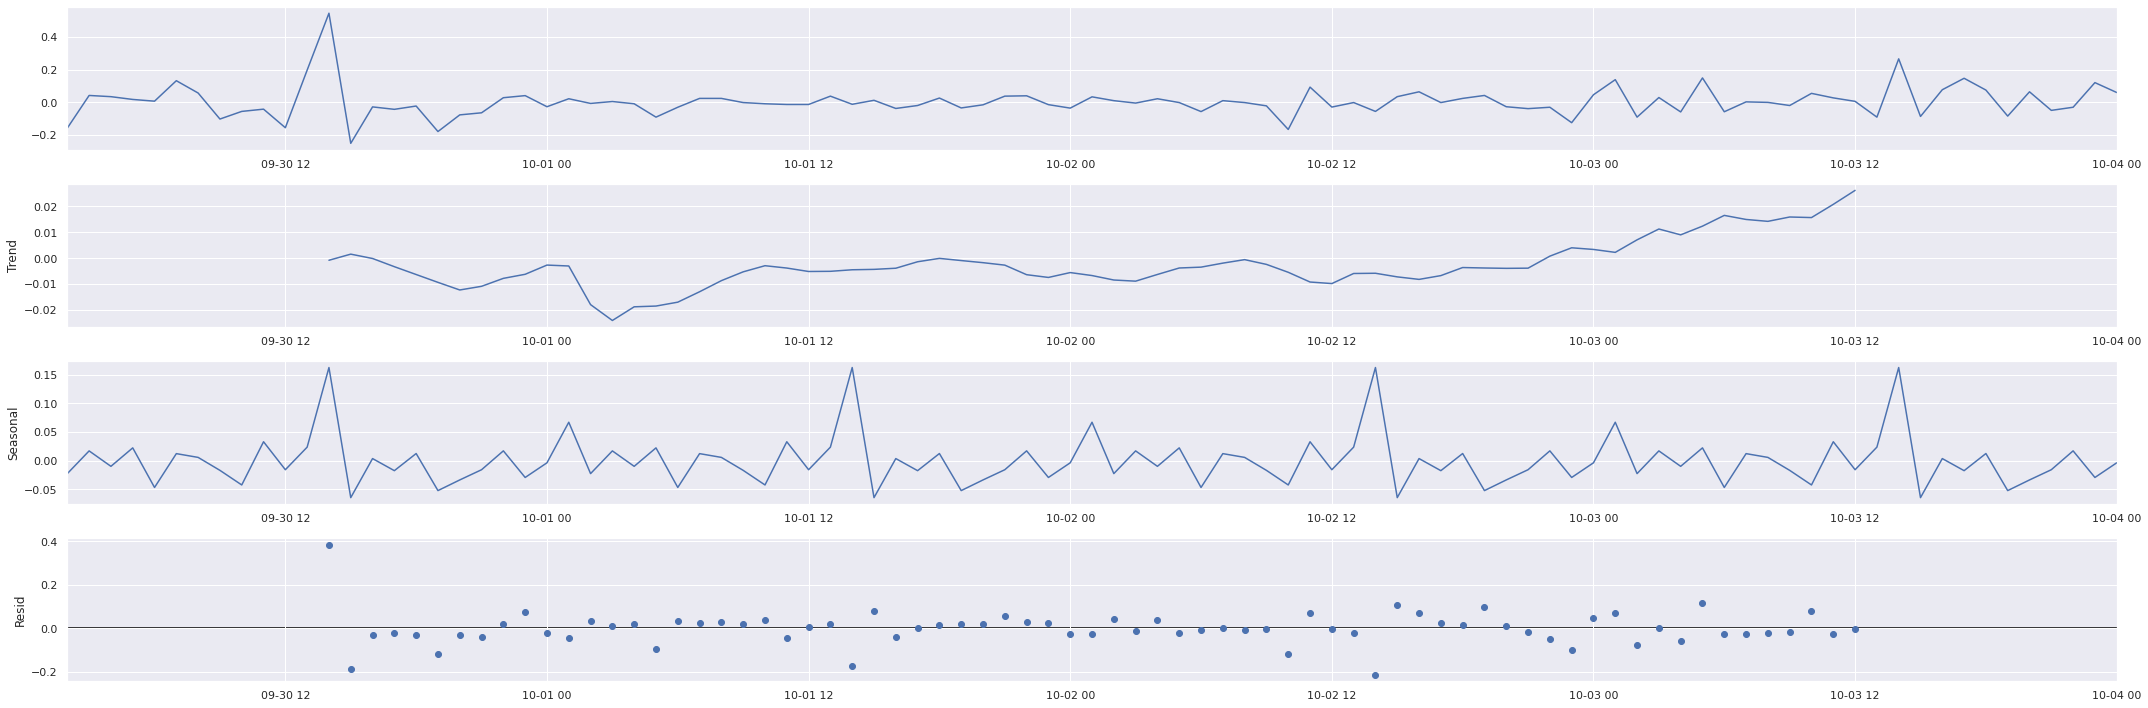

In [11]:
f.seasonal_decompose().plot();
plt.show();

#### Manual Arima

Based on previously found p,q,d parameters

In [12]:
f.manual_forecast(order=(1,1,0),call_me='manual-arima')


<AxesSubplot:xlabel='Date', ylabel='Values'>

Text(0.5, 1.0, 'ARIMA Test-Set Performance')

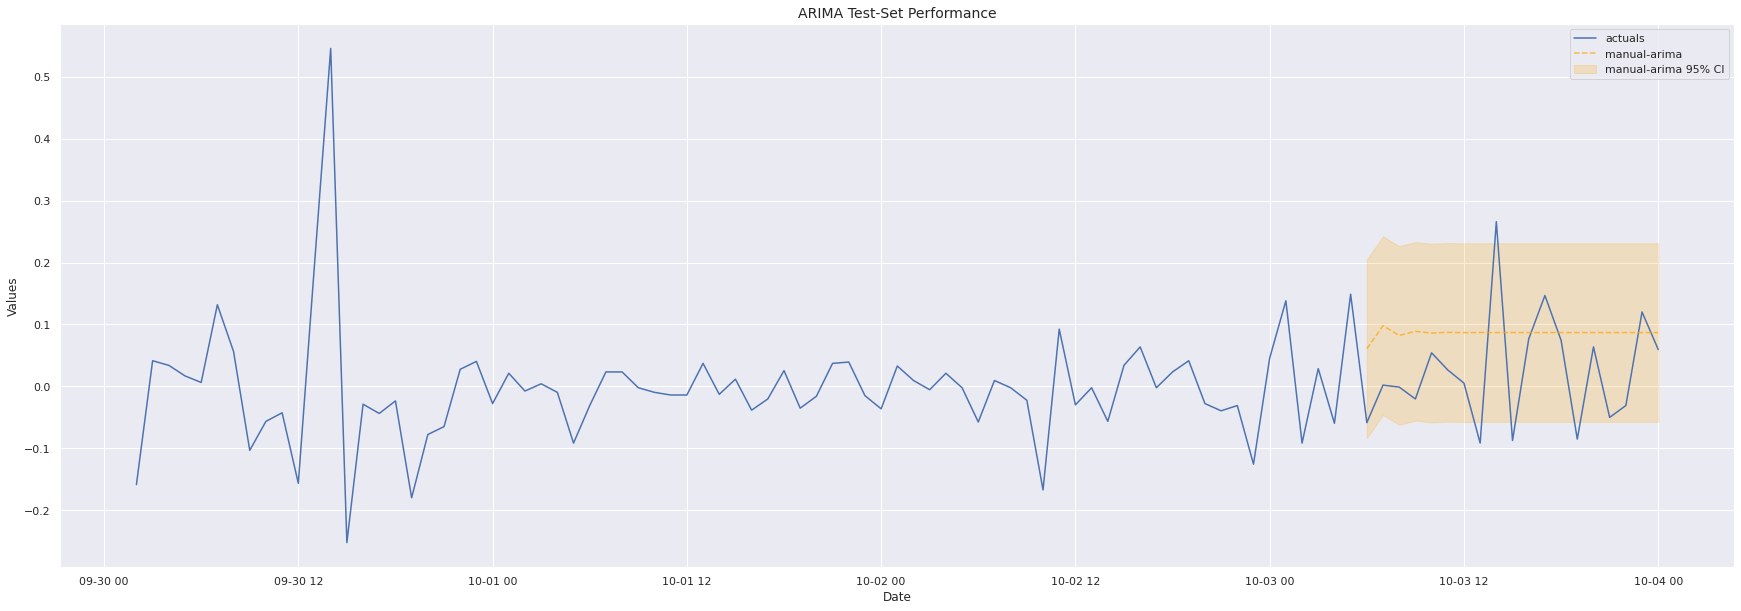

In [13]:
f.plot_test_set(ci=True) # view test results
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

In [14]:
f.regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   95
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  62.811
Date:                Tue, 11 Oct 2022   AIC                           -121.622
Time:                        11:04:56   BIC                           -116.536
Sample:                             0   HQIC                          -119.568
                                 - 95                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4788      0.048     -9.952      0.000      -0.573      -0.385
sigma2         0.0153      0.001     15.356      0.000       0.013       0.017
===================================================================================
Ljung-Box (L1) (Q):                   3.62   Jarque-Bera (JB):               310.47
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                            -0.43
Prob(H) (two-sided):                  0.01   Kurtosis:                        11.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Auto Arima

The model will find the best p,q,d parameters itself thanks to a gid-search approach

In [15]:
# fits a pmdarima auto model
auto_arima(
    f,
    max_p=6,
    max_q=6,
    max_d=6,
    max_P=2, 
    max_D=2,
    max_Q=2,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    scoring='mse',
    call_me='auto-arima',
    out_of_sample_size=2
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-143.362, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-137.923, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-136.353, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-136.776, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-139.812, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-144.194, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-141.538, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-141.787, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-142.633, Time=0.04 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 1.010 seconds


<AxesSubplot:xlabel='Date', ylabel='Values'>

Text(0.5, 1.0, 'ARIMA Test-Set Performance')

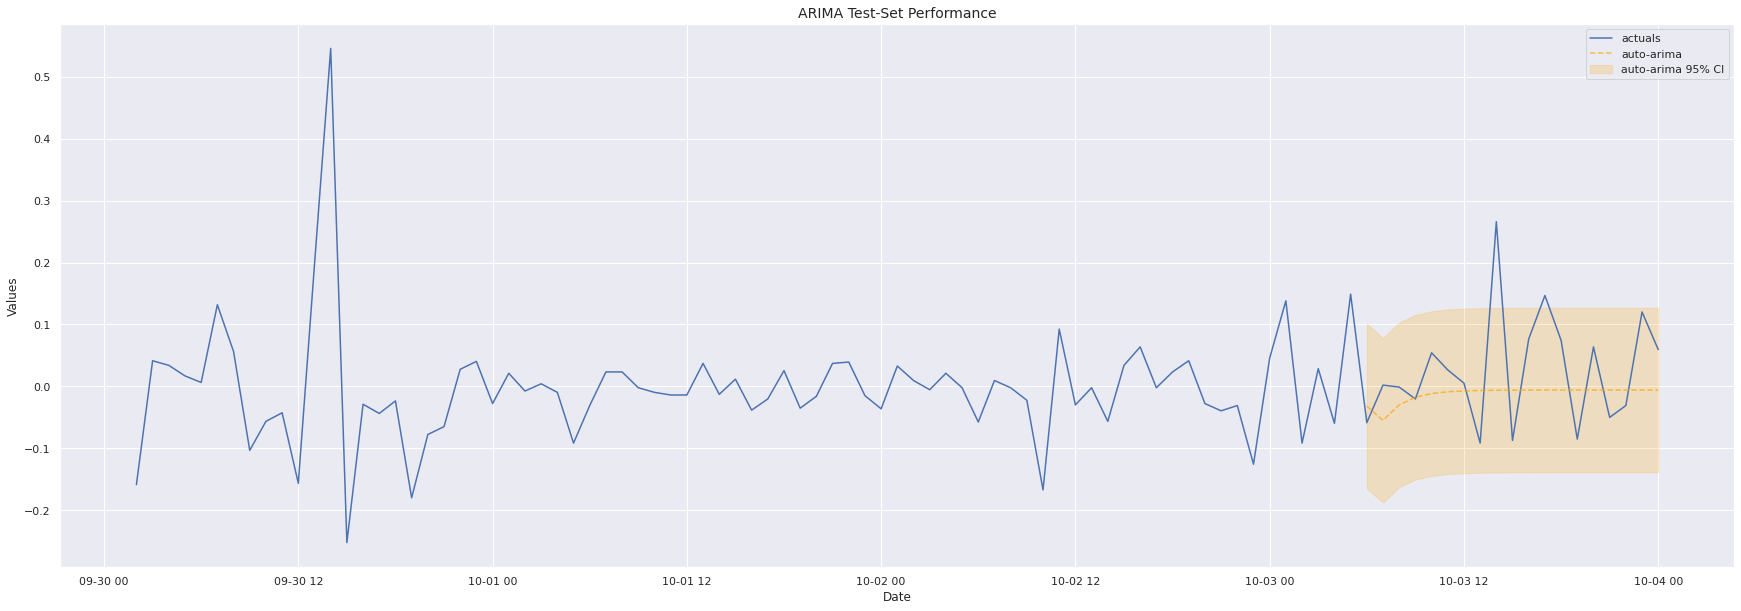

In [16]:
f.plot_test_set(ci=True,models='auto-arima')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

<AxesSubplot:xlabel='Date', ylabel='Values'>

Text(0.5, 1.0, 'ARIMA Forecast Performance')

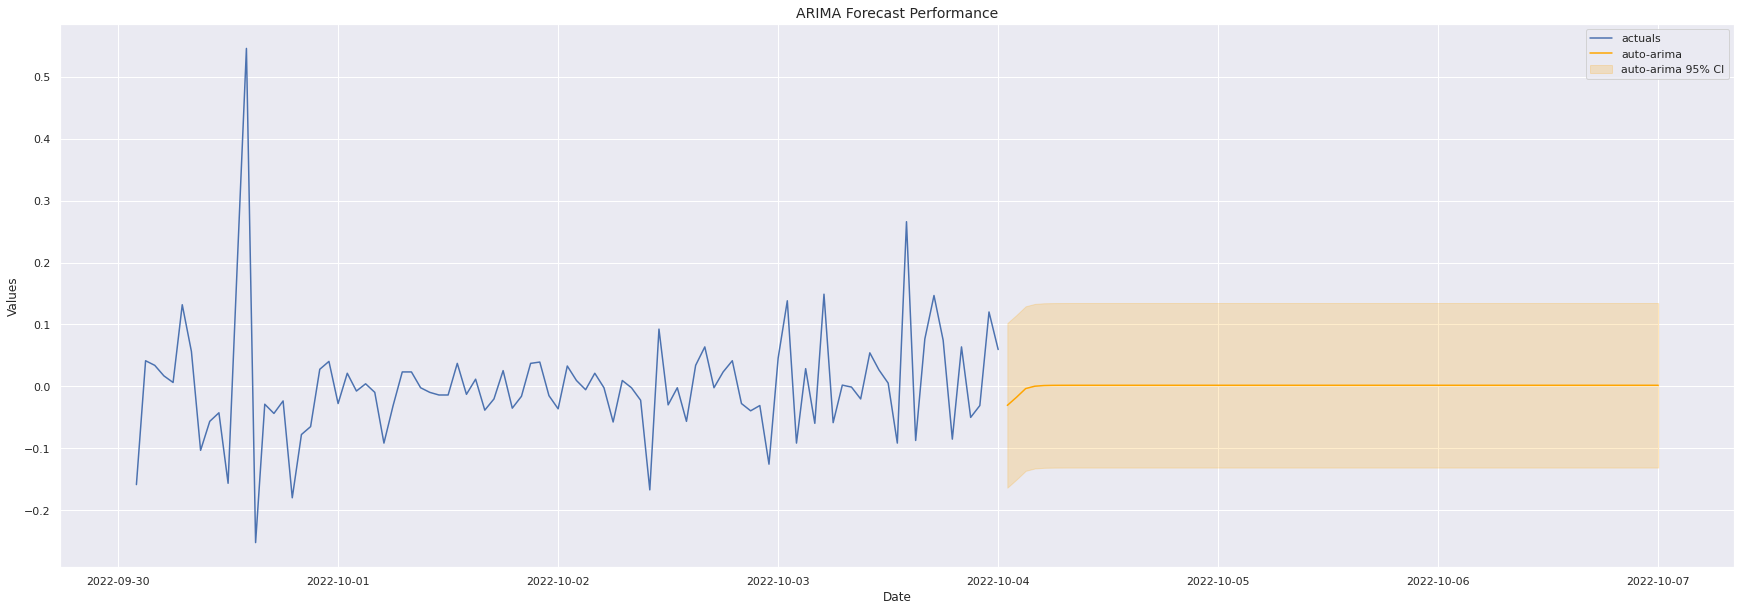

In [17]:
f.plot(ci=True,models='auto-arima')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

In [18]:
f.regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   95
Model:                 ARIMA(1, 0, 2)   Log Likelihood                  92.251
Date:                Tue, 11 Oct 2022   AIC                           -174.502
Time:                        11:04:58   BIC                           -161.733
Sample:                             0   HQIC                          -169.343
                                 - 95                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.007      0.257      0.797      -0.012       0.016
ar.L1          0.2743      0.566      0.485      0.628      -0.835       1.384
ma.L1         -0.4411      0.595     -0.741      0.459      -1.608       0.726
ma.L2         -0.1437      0.186     -0.771      0.441      -0.509       0.222
sigma2         0.0084      0.001      9.215      0.000       0.007       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               536.59
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                             2.10
Prob(H) (two-sided):                  0.03   Kurtosis:                        13.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### GluonTS - Transformer model

This part of the notebook is heavily based on the Quick Start Tutorial and the Extended Forecasting Tutorial that are both provided with the package.

In [19]:
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.transformer import TransformerEstimator
from gluonts.mx import Trainer
from gluonts.dataset.util import to_pandas
from gluonts.dataset.pandas import PandasDataset
from gluonts.mx.distribution.student_t import StudentTOutput
from gluonts.evaluation import make_evaluation_predictions

freq = "1h"
start = pd.Period("2022-09-05 00:00:00", freq=freq)
prediction_length = 6 # predict this many points
context_length = 200 # train on this number of points


train_ds = ListDataset(
    [{"start": btc_usd_h.index[0], "target": btc_usd_h.close[:-prediction_length]}],
    freq=freq
)

test_ds = ListDataset(
    [{"start": btc_usd_h.index[0], "target": btc_usd_h.close[:]}],
    freq=freq
)

In [20]:
from gluonts.evaluation import make_evaluation_predictions
from gluonts.evaluation import Evaluator


def make_predictions(predictor, ds, num_samples=100):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=num_samples,  # number of sample paths we want for evaluation
    )
    return list(forecast_it), list(ts_it)

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = context_length + prediction_length
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [ f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="cadetblue")
    plt.axvline(forecast_entry.start_date, color="g", lw=1) #end of train dataset
    plt.grid(which="major")
    plt.legend(legend, loc="upper left")
    plt.show()


def gluonts_metrics(tss, forecasts):
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(tss, forecasts)

    print(json.dumps(agg_metrics, indent=4))

#### DeepAR Estimator

DeepAR is a model provided by AWS, based on an RNN approach

In [21]:
estimator = DeepAREstimator(
	prediction_length=prediction_length, 
	context_length=context_length,
	freq=freq, 
	distr_output=StudentTOutput(),
	trainer=Trainer(
		epochs=5,
		learning_rate=1e-3,
		num_batches_per_epoch=100,
		patience=2
	)
)

predictor = estimator.train(training_data=train_ds)

100%|██████████| 100/100 [00:18<00:00,  5.42it/s, epoch=5/5, avg_epoch_loss=-2.23]


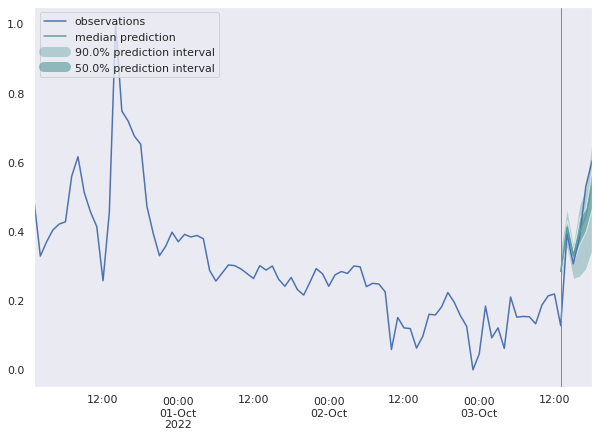

Running evaluation: 1it [00:00,  2.09it/s]

{
    "MSE": 0.0071275439113378525,
    "abs_error": 0.37163418531417847,
    "abs_target_sum": 2.3446807861328125,
    "abs_target_mean": 0.39078013102213544,
    "seasonal_error": 0.15294327735900878,
    "MASE": 0.40498040813068814,
    "MAPE": 0.2787346839904785,
    "sMAPE": 0.20367570718129477,
    "MSIS": 6.811585391898182,
    "QuantileLoss[0.1]": 0.3365484982728958,
    "Coverage[0.1]": 0.16666666666666666,
    "QuantileLoss[0.5]": 0.3716341704130173,
    "Coverage[0.5]": 0.6666666666666666,
    "QuantileLoss[0.9]": 0.10026331841945646,
    "Coverage[0.9]": 0.8333333333333334,
    "RMSE": 0.08442478256612719,
    "NRMSE": 0.2160416455803507,
    "ND": 0.15850097271754057,
    "wQuantileLoss[0.1]": 0.14353702229461282,
    "wQuantileLoss[0.5]": 0.1585009663622357,
    "wQuantileLoss[0.9]": 0.04276203354096029,
    "mean_absolute_QuantileLoss": 0.2694819957017898,
    "mean_wQuantileLoss": 0.11493334073260293,
    "MAE_Coverage": 0.09999999999999998,
    "OWA": NaN
}


In [22]:
(forecasts, tss) = make_predictions(predictor, train_ds, 24)
plot_prob_forecasts(tss[0], forecasts[0])
gluonts_metrics(tss, forecasts)


#### Transformer Estimator

In [23]:
transformerEstimator = TransformerEstimator(
    prediction_length=prediction_length, 
	context_length=context_length,
	freq=freq, 
	distr_output=StudentTOutput(),
	trainer=Trainer(
		epochs=5,
		learning_rate=1e-3,
		num_batches_per_epoch=100,
		patience=2
	)
    
    )
predictorTransformer = transformerEstimator.train(training_data=train_ds)

100%|██████████| 100/100 [00:13<00:00,  7.53it/s, epoch=5/5, avg_epoch_loss=-1.62]


<AxesSubplot:>

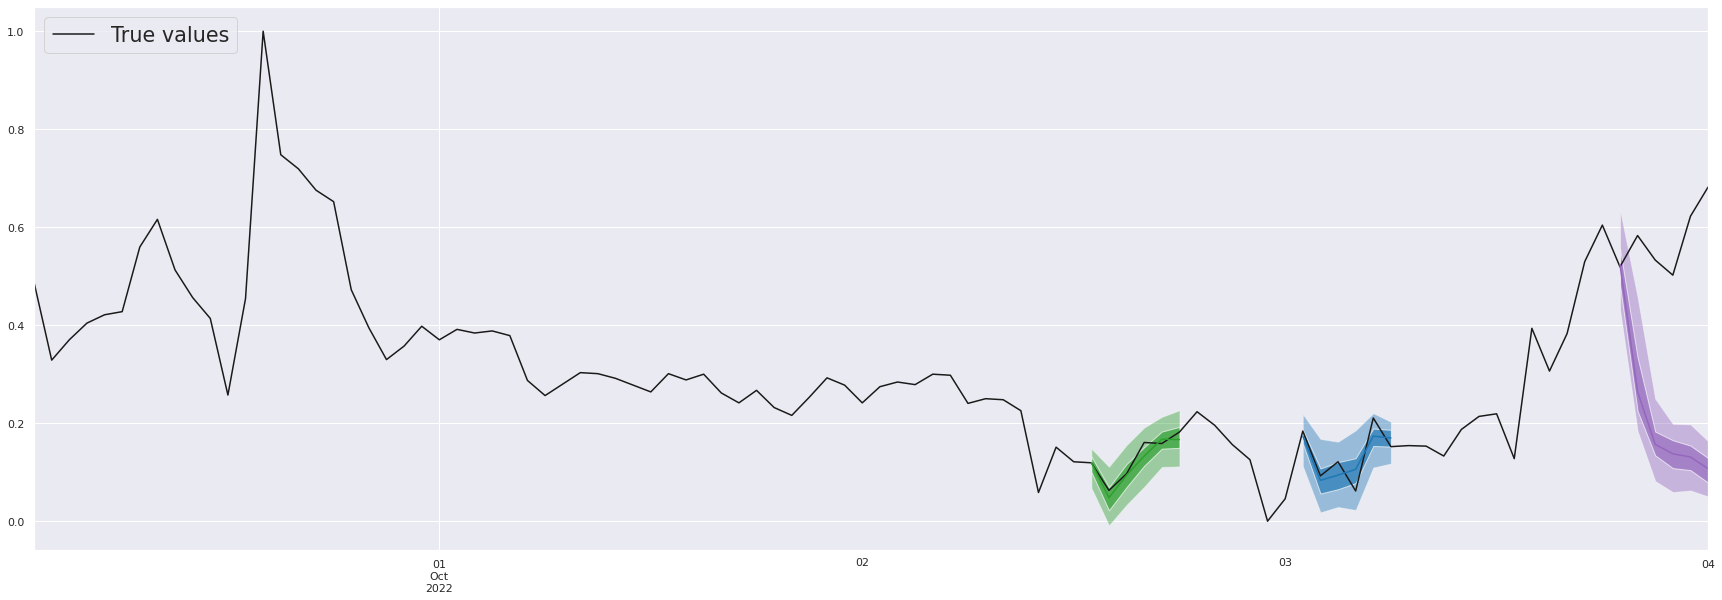

In [24]:

# Make predictions
true_values = to_pandas(list(test_ds)[0])
true_values.to_timestamp().plot(color="k")

prediction_input = PandasDataset([true_values[:-36], true_values[:-24], true_values[:-6]])
predictions = predictorTransformer.predict(prediction_input)

for color, prediction in zip(["green", "blue", "purple"], predictions):
    prediction.plot(color=f"tab:{color}")

plt.legend(["True values"], loc="upper left", fontsize="xx-large")

array([0.48723406, 0.3287234 , 0.37021276, 0.40425533, 0.4212766 ],
      dtype=float32)

array([0.48723406, 0.3287234 , 0.37021276, 0.40425533, 0.4212766 ],
      dtype=float32)

Number of sample paths: 24
Dimension of samples: (24, 6)
Start date of the forecast window: 2022-10-03 13:00
Frequency of the time series: <Hour>
Mean of the future window:
 [0.11309165 0.43719387 0.41099003 0.49036944 0.56114155 0.56524885]
0.5-quantile (median) of the future window:
 [0.11809041 0.45009962 0.40833664 0.49005738 0.5702974  0.5678204 ]


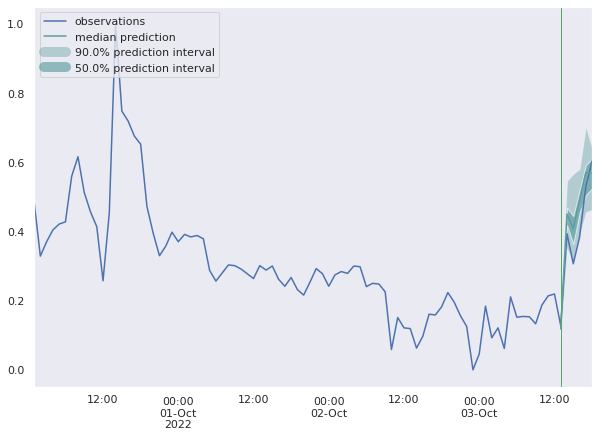

In [25]:
(forecasts, tss) = make_predictions(predictorTransformer, train_ds, 24)
ts_entry = tss[0]
np.array(ts_entry[:5]).reshape(-1,)
dataset_test_entry = next(iter(test_ds))
dataset_test_entry["target"][:5]

forecast_entry = forecasts[0]
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")
plot_prob_forecasts(ts_entry, forecast_entry)

In [26]:
gluonts_metrics(tss, forecasts)


Running evaluation: 1it [00:00,  1.68it/s]

{
    "MSE": 0.004515193402767181,
    "abs_error": 0.35202911496162415,
    "abs_target_sum": 2.3446807861328125,
    "abs_target_mean": 0.39078013102213544,
    "seasonal_error": 0.15294327735900878,
    "MASE": 0.3836162018586087,
    "MAPE": 0.1612627605597178,
    "sMAPE": 0.14636443058649698,
    "MSIS": 1.7257126085193872,
    "QuantileLoss[0.1]": 0.1240106076002121,
    "Coverage[0.1]": 0.3333333333333333,
    "QuantileLoss[0.5]": 0.35202910751104355,
    "Coverage[0.5]": 0.6666666666666666,
    "QuantileLoss[0.9]": 0.1382836878299713,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.06719518883645749,
    "NRMSE": 0.17195139543225976,
    "ND": 0.15013946335195658,
    "wQuantileLoss[0.1]": 0.052890188009237865,
    "wQuantileLoss[0.5]": 0.15013946017430416,
    "wQuantileLoss[0.9]": 0.05897761803987348,
    "mean_absolute_QuantileLoss": 0.20477446764707566,
    "mean_wQuantileLoss": 0.08733575540780518,
    "MAE_Coverage": 0.16666666666666663,
    "OWA": NaN
}
